# Notebook for Neural Network Downsampled

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pipe import select, where, sort
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, fbeta_score, make_scorer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.utils import resample
import presentation as p 

In [3]:
training_df = pd.read_csv('data/network-traffic/kddcup.data.corrected.csv', index_col=False).drop_duplicates()
testing_df = pd.read_csv('data/network-traffic/corrected.csv', index_col=False).drop_duplicates()
complete_df = pd.read_csv('data/network-traffic/kddcup.data.complete.csv', index_col=False).drop_duplicates()

In [4]:
# Create column to verify if it is an attack or not
training_df['is_attack'] = training_df.target.map(lambda a_type: a_type != 'normal')
testing_df['is_attack'] = testing_df.target.map(lambda a_type: a_type != 'normal')
complete_df['is_attack'] = complete_df.target.map(lambda a_type: a_type != 'normal')

In [6]:
categorical_columns = ['protocol_type', 'service', 'flag', 'target', 'attack_class', 'is_attack']

label_encoder = LabelEncoder()
# Fit the label encoder on the complete dataset
for col in categorical_columns:
    label_encoder.fit(complete_df[col])
    training_df[col] = label_encoder.transform(training_df[col])
    testing_df[col] = label_encoder.transform(testing_df[col])
    complete_df[col] = label_encoder.transform(complete_df[col])

In [7]:
# Metrics
beta =10
fbeta_average = 'weighted'
fbeta_scorer = make_scorer(fbeta_score, beta=beta)

# Train and Test Data

In [8]:
# Attack Detection Original Data
X_train_attack = training_df.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_train_attack = training_df['is_attack']

X_test_attack = testing_df.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_test_attack = testing_df['is_attack']

# Attack Classification Original Data
X_train_class = training_df[training_df['attack_class'] != 1].drop(['target', 'attack_class', 'is_attack'], axis=1)
y_train_class = training_df[training_df['attack_class'] != 1]['attack_class']

X_test_class = testing_df[testing_df['attack_class'] != 1].drop(['target', 'attack_class', 'is_attack'], axis=1)
y_test_class = testing_df[testing_df['attack_class'] != 1]['attack_class']

In [23]:
training_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,attack_class,is_attack
0,0,1,24,9,215,45076,0,0,0,0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,16,1,0
1,0,1,24,9,162,4528,0,0,0,0,...,0.0,1.00,0.0,0.0,0.0,0.0,0.0,16,1,0
2,0,1,24,9,236,1228,0,0,0,0,...,0.0,0.50,0.0,0.0,0.0,0.0,0.0,16,1,0
3,0,1,24,9,233,2032,0,0,0,0,...,0.0,0.33,0.0,0.0,0.0,0.0,0.0,16,1,0
4,0,1,24,9,239,486,0,0,0,0,...,0.0,0.25,0.0,0.0,0.0,0.0,0.0,16,1,0


In [10]:
# Check class distribution before downsampling
print("Class distribution before downsampling:")
print(training_df['is_attack'].value_counts())
print(training_df['attack_class'].value_counts())

Class distribution before downsampling:
is_attack
0    812814
1    262178
Name: count, dtype: int64
attack_class
1    812814
0    247267
2     13860
3       999
4        52
Name: count, dtype: int64


In [11]:
# Separate majority and minority classes for attack detection
majority_class_attack = training_df[training_df.is_attack == 0]
minority_class_attack = training_df[training_df.is_attack == 1]

# Down sample the majority class for attack detection
majority_class_attack_downsampled = resample(majority_class_attack,
                                             replace=False,  # sample without replacement
                                             n_samples=len(minority_class_attack),  # to match minority class
                                             random_state=404)  # reproducible results

# Combine minority class with downsampled majority class
downsampled_df_attack = pd.concat([majority_class_attack_downsampled, minority_class_attack])

# Separate features and target for the downsampled attack detection dataset
X_train_attack_resampled = downsampled_df_attack.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_train_attack_resampled = downsampled_df_attack['is_attack']

# Similarly, for attack classification
# Separate majority and minority classes
majority_class_class = training_df[training_df.attack_class == 1]  # Assuming 0 is the majority class
minority_class_class = training_df[training_df.attack_class != 1]  # All other classes as minority

# Down sample the majority class for attack classification
majority_class_class_downsampled = resample(majority_class_class,
                                            replace=False,  # sample without replacement
                                            n_samples=len(minority_class_class),  # to match minority class
                                            random_state=404)  # reproducible results

# Combine minority class with downsampled majority class
downsampled_df_class = pd.concat([majority_class_class_downsampled, minority_class_class])

# Separate features and target for the downsampled attack classification dataset
X_train_class_resampled = downsampled_df_class.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_train_class_resampled = downsampled_df_class['attack_class']

Attack Detection Class Distribution after down sampling: is_attack
0    262178
1    262178
Name: count, dtype: int64
Attack Classification Class Distribution after down sampling: attack_class
1    262178
0    247267
2     13860
3       999
4        52
Name: count, dtype: int64


In [ ]:
# One-hot encoding for the resampled y_train_class and y_test_class
y_train_class_resampled_enc = pd.get_dummies(y_train_class_resampled, prefix='class')
y_test_class_enc = pd.get_dummies(y_test_class, prefix='class')

# Checking the class distribution after down sampling
print(f"Attack Detection Class Distribution after down sampling: {pd.Series(y_train_attack_resampled).value_counts()}")
print(f"Attack Classification Class Distribution after down sampling: {pd.Series(y_train_class_resampled).value_counts()}")

# Neural Network down sampled

In [56]:
# Set random seed for TensorFlow
tf.random.set_seed(404)

# Define the metrics you want to use
metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.Accuracy(), 
            tf.keras.metrics.FBetaScore(beta=10.0, threshold=.5, average='weighted')]


In [13]:
# Create Model
nn_attack_model = Sequential([
        Input(shape=(X_train_attack_resampled.shape[1],), batch_size=128),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

# Compile the Attack Detection Model
nn_attack_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics])

In [53]:
nn_class_model = Sequential([
        Input(shape=(X_train_class_resampled.shape[1],), batch_size=128),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(y_train_class_resampled_enc.shape[1], activation='softmax')  # Output layer for multi classification
    ])

# Compile the Attack Classification Model
nn_class_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metrics])


In [15]:
# Train the Neural Network models with adjusted parameters
history_attack_resampled = nn_attack_model.fit(
    X_train_attack_resampled, y_train_attack_resampled,
    epochs=50, validation_split=0.2
)

Epoch 1/50
13109/13109 ━━━━━━━━━━━━━━━━━━━━ 7s 464us/step - fbeta_score: 0.9575 - loss: 140.9480 - val_fbeta_score: 0.9899 - val_loss: 0.0318
Epoch 2/50
13109/13109 ━━━━━━━━━━━━━━━━━━━━ 6s 457us/step - fbeta_score: 0.9722 - loss: 0.1000 - val_fbeta_score: 0.9897 - val_loss: 0.0491
Epoch 3/50
13109/13109 ━━━━━━━━━━━━━━━━━━━━ 6s 454us/step - fbeta_score: 0.9742 - loss: 0.0721 - val_fbeta_score: 0.9917 - val_loss: 0.0252
Epoch 4/50
13109/13109 ━━━━━━━━━━━━━━━━━━━━ 6s 457us/step - fbeta_score: 0.9763 - loss: 1.5940 - val_fbeta_score: 0.9940 - val_loss: 0.0183
Epoch 5/50
13109/13109 ━━━━━━━━━━━━━━━━━━━━ 6s 458us/step - fbeta_score: 0.9781 - loss: 0.0526 - val_fbeta_score: 0.9920 - val_loss: 0.0269
Epoch 6/50
13109/13109 ━━━━━━━━━━━━━━━━━━━━ 6s 449us/step - fbeta_score: 0.9792 - loss: 3.7149 - val_fbeta_score: 0.9962 - val_loss: 0.0131
Epoch 7/50
13109/13109 ━━━━━━━━━━━━━━━━━━━━ 6s 464us/step - fbeta_score: 0.9797 - loss: 0.0416 - val_fbeta_score: 0.9960 - val_loss: 0.0155
Epoch 8/50
13109/1

In [54]:
history_class_resampled = nn_class_model.fit(
    X_train_class_resampled, y_train_class_resampled_enc,
    epochs=50, validation_split=0.2
)

Epoch 1/50
13109/13109 ━━━━━━━━━━━━━━━━━━━━ 7s 509us/step - accuracy: 0.8570 - loss: 0.0953 - precision_1: 0.9429 - recall_1: 0.9428 - val_accuracy: 0.8922 - val_loss: 0.0858 - val_precision_1: 0.9788 - val_recall_1: 0.9788
Epoch 2/50
13109/13109 ━━━━━━━━━━━━━━━━━━━━ 7s 513us/step - accuracy: 0.9272 - loss: 0.0867 - precision_1: 0.9755 - recall_1: 0.9754 - val_accuracy: 0.7575 - val_loss: 0.0990 - val_precision_1: 0.9285 - val_recall_1: 0.9285
Epoch 3/50
13109/13109 ━━━━━━━━━━━━━━━━━━━━ 7s 512us/step - accuracy: 0.9243 - loss: 0.0851 - precision_1: 0.9815 - recall_1: 0.9814 - val_accuracy: 0.6403 - val_loss: 0.1858 - val_precision_1: 0.6010 - val_recall_1: 0.6010
Epoch 4/50
13109/13109 ━━━━━━━━━━━━━━━━━━━━ 6s 489us/step - accuracy: 0.9150 - loss: 0.0840 - precision_1: 0.9856 - recall_1: 0.9855 - val_accuracy: 0.6035 - val_loss: 0.1447 - val_precision_1: 0.7547 - val_recall_1: 0.7547
Epoch 5/50
13109/13109 ━━━━━━━━━━━━━━━━━━━━ 6s 481us/step - accuracy: 0.9552 - loss: 0.0839 - precision_

In [61]:
# Evaluate the attack detection model
attack_detection_loss, attack_detection_accuracy = nn_attack_model.evaluate(X_test_attack, y_test_attack)
print(f"Attack Detection - Loss: {attack_detection_loss}, Accuracy: {attack_detection_accuracy}")

# Evaluate the attack classification model
attack_classification_loss, attack_classification_accuracy = nn_class_model.evaluate(X_test_class, y_test_class_enc)
#print(f"Attack Classification - Loss: {attack_classification_loss}, Accuracy: {attack_classification_accuracy}")
print(f'Neural Network Attack Classification Accuracy: {accuracy:.2f}')


2416/2416 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step - fbeta_score: 0.7436 - loss: 0.7327
Attack Detection - Loss: 0.6529197096824646, Accuracy: 0.8179044723510742


2024-07-12 18:50:45.489097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [1,160] vs. [1,128]
	 [[{{node LogicalAnd}}]]


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/nyesil/.pyenv/versions/3.11.3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Users/nyesil/.pyenv/versions/3.11.3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Users/nyesil/.pyenv/versions/3.11.3/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/b6/wr4g79gx0k9dgk9772mcm8gh0000gn/T/ipykernel_5987/2278077382.py", line 6, in <module>

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 429, in evaluate

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 91, in test_step

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/keras/src/trainers/trainer.py", line 444, in compute_metrics

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 330, in update_state

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 17, in update_state

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/keras/src/metrics/confusion_metrics.py", line 378, in update_state

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/keras/src/metrics/metrics_utils.py", line 592, in update_confusion_matrix_variables

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/keras/src/metrics/metrics_utils.py", line 565, in weighted_assign_add

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 3247, in logical_and

  File "/Users/nyesil/Documents/Greenbootcamps/Final_Project/Your-Data-Is-Mine/.tensor-venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 1420, in logical_and

Incompatible shapes: [1,160] vs. [1,128]
	 [[{{node LogicalAnd}}]] [Op:__inference_one_step_on_iterator_11185270]

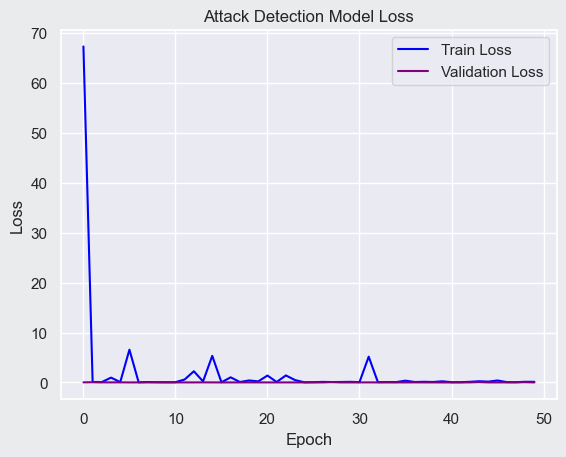

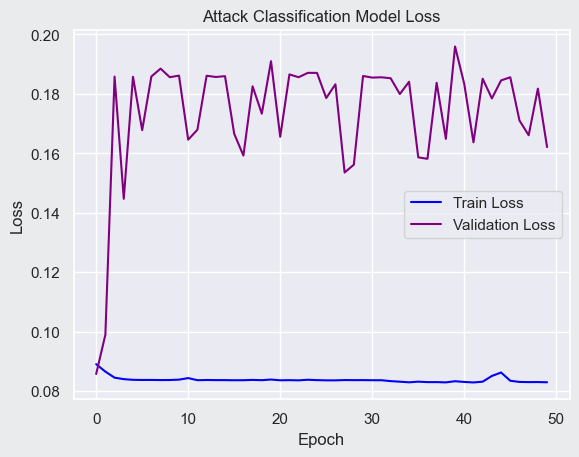

In [64]:
# Plot training history for Attack Detection Model
plt.plot(history_attack_resampled.history['loss'], color='blue', label='Train Loss')
plt.plot(history_attack_resampled.history['val_loss'], color='purple', label='Validation Loss')
plt.title('Attack Detection Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot training history for Attack Classification Model
plt.plot(history_class_resampled.history['loss'], color='blue', label='Train Loss')
plt.plot(history_class_resampled.history['val_loss'], color='purple', label='Validation Loss')
plt.title('Attack Classification Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='right')
plt.show()

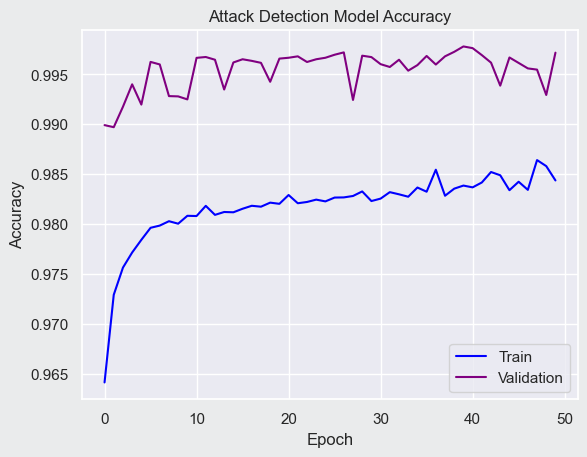

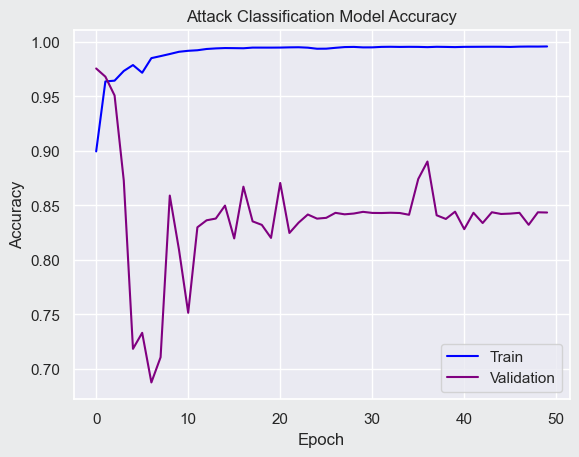

In [32]:
# Visualize the Architecture for Attack Detection
plt.plot(history_attack_resampled.history['fbeta_score'], color='blue')
plt.plot(history_attack_resampled.history['val_fbeta_score'], color='purple')
plt.title('Attack Detection Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Visualize the Architecture for Attack Classification
plt.plot(history_class_resampled.history['accuracy'], color='blue')
plt.plot(history_class_resampled.history['val_accuracy'], color='purple')
plt.title('Attack Classification Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [33]:
# Pedictions for Attack Detection (Binary)
nn_attack_pred = nn_attack_model.predict(X_test_attack)
predicted_labels_attack = np.where(nn_attack_pred > 0.5, 1, 0)  # Thresholding at 0.5 for binary classification

# Display the first few test samples and their predictions
for i in range(5):
    print(f"Sample {i+1}: True Label: {y_test_attack[i]}, Predicted Label: {predicted_labels_attack[i]}")

2416/2416 ━━━━━━━━━━━━━━━━━━━━ 1s 244us/step
Sample 1: True Label: 0, Predicted Label: [0]
Sample 2: True Label: 1, Predicted Label: [0]
Sample 3: True Label: 1, Predicted Label: [0]
Sample 4: True Label: 1, Predicted Label: [0]
Sample 5: True Label: 0, Predicted Label: [0]


In [34]:
# Predictions for Attack Classification (Multi-class)
nn_class_pred = nn_class_model.predict(X_test_class)
predicted_labels_class = np.argmax(nn_class_pred, axis=1)

# Convert y_test_class_enc to a NumPy array if it isn't already
y_test_class_enc_np = y_test_class_enc.values if isinstance(y_test_class_enc, pd.DataFrame) else y_test_class_enc

# Display the first few test samples and their predictions
for i in range(5):
    true_label = np.argmax(y_test_class_enc_np[i]) 
    print(f"Sample {i+1}: True Label: {true_label}, Predicted Label: {predicted_labels_class[i]}")

919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
Sample 1: True Label: 0, Predicted Label: 1
Sample 2: True Label: 0, Predicted Label: 1
Sample 3: True Label: 0, Predicted Label: 1
Sample 4: True Label: 0, Predicted Label: 1
Sample 5: True Label: 0, Predicted Label: 1


Confusion Matrix Attack Detection Neural Network


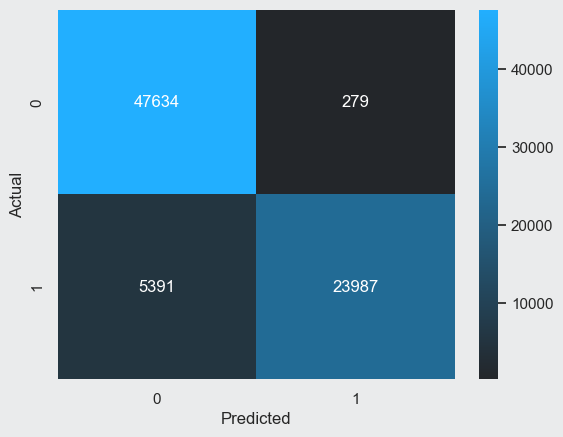

In [35]:
# Confusion Matrix for Attack Detection with Neural Network
print('Confusion Matrix Attack Detection Neural Network')
nn_conf_matrix_attack = confusion_matrix(y_test_attack, predicted_labels_attack)
sns.heatmap(nn_conf_matrix_attack, annot=True, fmt='d', cmap=p.Colors.blues_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Confusion Matrix Attack Classification Neural Network


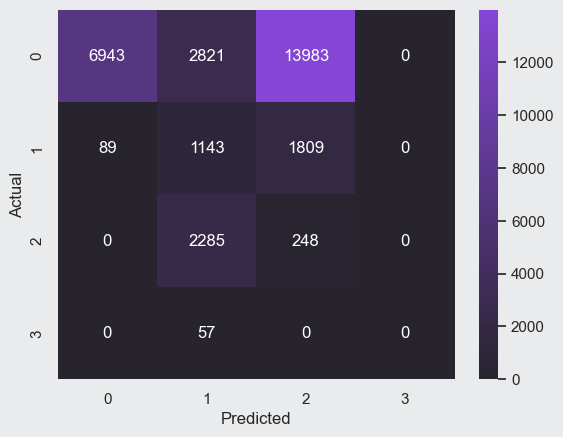

In [36]:
# Convert one-hot encoded y_test_class_enc to class labels
true_labels_class = np.argmax(y_test_class_enc.values, axis=1) if isinstance(y_test_class_enc, pd.DataFrame) else np.argmax(y_test_class_enc, axis=1)

# Confusion Matrix for Attack Classification with Neural Network
print('Confusion Matrix Attack Classification Neural Network')
nn_conf_matrix_class = confusion_matrix(true_labels_class, predicted_labels_class)

# Plot the confusion matrix
sns.heatmap(nn_conf_matrix_class, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()